In [2]:
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_squared_error,r2_score 

import warnings
warnings.filterwarnings('ignore')
breast_cancer = load_breast_cancer()

import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

In [2]:
2863288%5

3

Обработка данных

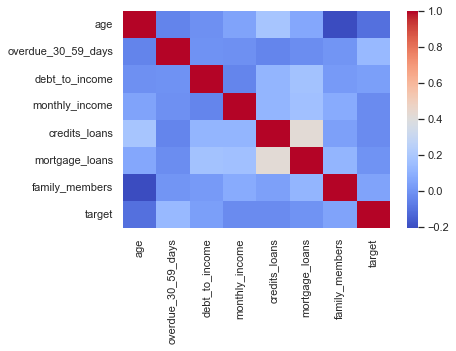

In [3]:

X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_train= X_train.fillna({"monthly_income": X_train.monthly_income.median()})
X_train= X_train.fillna({"family_members": X_train.monthly_income.median()})

mas = pd.concat([X_train, y_train], axis=1)
mas = mas.where(mas['age'] > 10)
mas = mas.where(mas['age'] < 100)
mas = mas.where(mas['monthly_income'] > 100)
mas = mas[(mas['monthly_income'] < 5300) | (mas['monthly_income']  > 5400)]
mas = mas.where(mas['family_members'] < 100)
mas = mas.dropna()
mas = mas.drop(columns= ['overdue__more_than_90_days'])
mas = mas.drop(columns= ['overdue_60_89_days'])
mas = mas.drop(columns= ['credit_card_utilization'])
x = mas.drop(columns= ['target'])
#x = preprocessing.normalize(x)
#x_scaled = pd.DataFrame(x)
y = mas['target']
x_t = pd.read_csv("X_test.csv")
x_t= x_t.fillna({"monthly_income":x_t.monthly_income.median()})
x_t= x_t.fillna({"family_members":x_t.monthly_income.median()})
x_t = x_t.drop(columns = ['credit_card_utilization'])
x_t = x_t.drop(columns = ["overdue__more_than_90_days"])
x_t = x_t.drop(columns= ['overdue_60_89_days'])
x_test = x_t.drop(columns= ['index'])
#clf.fit(x, y)
#parametrs = {"criterion": ["gini" , "entropy"], "max_depth" : range(4,9),'min_samples_leaf': range(1000, 10000, 1000),'min_samples_split': range(2000, 30000, 2000) }
#grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5 )
#grid_search_cv_clf.fit(x, y)
#grid_search_cv_clf.best_params
sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100
g = sns.heatmap(mas.corr(),annot=False, fmt = ".2f", cmap = "coolwarm") #корреляционная матрица

Нормализация данных

In [4]:
from sklearn import preprocessing
x = preprocessing.normalize(x)
x = pd.DataFrame(x)
x_test = preprocessing.normalize(x_test)
x_test = pd.DataFrame(x_test)

Импорт градиентного бустинга и обучение модели

In [5]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

param_grid = {
    'n_estimators':range(13,14),
    "max_depth": range(3,4),
}
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5, scoring="roc_auc")
_ = grid_cv.fit(x,y)
grid_cv.best_params_

{'max_depth': 3, 'n_estimators': 13}

In [6]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    colsample_bytree=0.5,
    subsample=0.8
)

In [7]:
_ = final_cl.fit(x, y)

Экспорт CSV с ответами

In [10]:
y_predicted_proba = pd.DataFrame(final_cl.predict_proba(x_test))
result = pd.concat([y_predicted_proba, x_t], axis=1)
result = result.rename(columns={1: "target"})
result = result[{'target', 'index'}]
prediction = result.to_csv('prediction_boosting.csv', index = False)

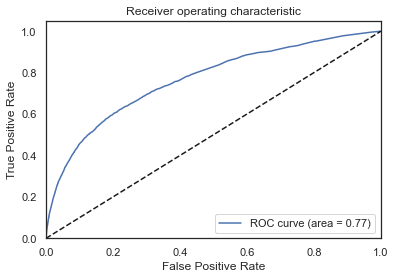

In [11]:
y_predict_proba = final_cl.predict_proba(x)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_predict_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Аналогичный процесс для random forest

In [12]:
clf_rf = RandomForestClassifier()

parametrs = {'n_estimators':range(10,12), 'max_depth': range(9,10)}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(x,y)
grid_search_cv_clf.best_params_
clf_rf =  RandomForestClassifier(
    **grid_cv.best_params_
)
_ = clf_rf.fit(x, y)

In [13]:
y_predicted_proba = pd.DataFrame(clf_rf.predict_proba(x_test))
result = pd.concat([y_predicted_proba, x_t], axis=1)
result = result.rename(columns={1: "target"})
result = result[{'target', 'index'}]
prediction = result.to_csv('prediction_rf.csv', index = False)

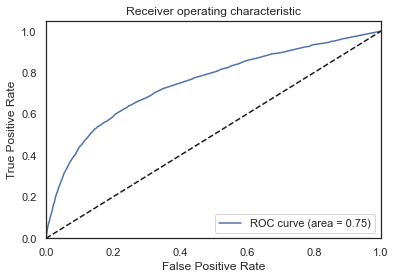

In [14]:
y_predict_proba = clf_rf.predict_proba(x)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_predict_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

А теперь обычное дерево

In [21]:
scores_data = pd.DataFrame()
for max_depth in range(3,7):
  clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = max_depth)
  clf.fit(x, y)
  train_score = clf.score(x, y)
  test_score = clf.score(x, y)
  mean_cross_val_score = cross_val_score(clf, x, y, cv = 5).mean()
  temp_score_data = pd.DataFrame({"max_depth": [max_depth], "train_score" : [train_score], "test_score": [test_score], "mean_cross_val_score": [mean_cross_val_score]})
  scores_data = scores_data.append(temp_score_data)

<AxesSubplot:xlabel='max_depth', ylabel='score'>

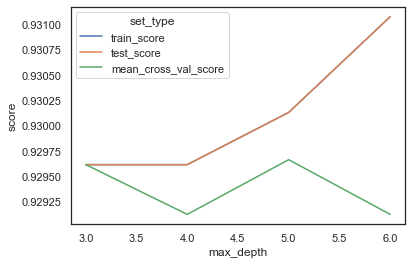

In [22]:
scores_data_long = pd.melt(scores_data, id_vars = ["max_depth"], value_vars = ["train_score", "test_score", "mean_cross_val_score"], var_name = "set_type", value_name= "score")
sns.lineplot(x = "max_depth", y = "score", hue = "set_type", data = scores_data_long )

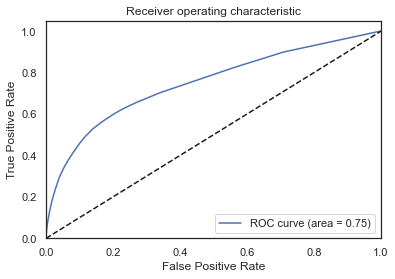

In [23]:
y_predict_proba = clf.predict_proba(x)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_predict_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")